# Text Classification using BERT

##**1. Setup Environment**

In [1]:
!pip install -q datasets==3.6.0 accelerate evaluate transformers tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.1 MB/s eta 0:00:00


In [11]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [16]:
import glob
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.metrics import classification_report
from transformers import TrainingArguments, Trainer
from transformers import AutoConfig, AutoModelForSequenceClassification
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [19]:
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##**2. Load Dataset**

In [20]:
### COMPLETE THE CODE HERE
ds = load_dataset("uitnlp/vietnamese_students_feedback")

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

##**3. Preprocessing**

### 3.1 Load Tokenizer

In [21]:
### COMPLETE THE CODE HERE
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name,
                                        use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
tokenizer.model_max_length

512

### 3.2 Tokenize Dataset

In [22]:
max_seq_length = 100
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    ### COMPLETE THE CODE HERE
    result = tokenizer(examples["sentence"],
                        padding="max_length",
                        truncation=True,
                        max_length=max_seq_length)

    result["label"] = examples["sentiment"]

    return result

In [23]:
### COMPLETE THE CODE HERE
processed_dataset = ds.map(
    preprocess_function,
    batched=True,
    desc=" Running tokenizer on dataset"
)

 Running tokenizer on dataset:   0%|          | 0/11426 [00:00<?, ? examples/s]

 Running tokenizer on dataset:   0%|          | 0/1583 [00:00<?, ? examples/s]

 Running tokenizer on dataset:   0%|          | 0/3166 [00:00<?, ? examples/s]

In [24]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic', 'input_ids', 'attention_mask', 'label'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic', 'input_ids', 'attention_mask', 'label'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic', 'input_ids', 'attention_mask', 'label'],
        num_rows: 3166
    })
})

##**4. Modeling**

In [25]:
num_labels = 3

### COMPLETE THE CODE HERE
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task="text-classification"
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


##**5. Trainer**

In [27]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

In [28]:
training_args = TrainingArguments(
    output_dir="vsfc-distilbert-base-uncased",
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=10,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="tensorboard"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/tmp/ipython-input-2668178693.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


##**6. Training**

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.670900,0.454080,0.845862
2,0.403900,0.355815,0.881238
3,0.341800,0.349446,0.885028
4,0.304600,0.312706,0.893241
5,0.280500,0.308391,0.897663
6,0.260900,0.299000,0.902716
7,0.243600,0.293251,0.902716
8,0.232700,0.291672,0.900821
9,0.222500,0.294559,0.901453
10,0.216200,0.293134,0.902085


TrainOutput(global_step=450, training_loss=0.3177583207024468, metrics={'train_runtime': 880.3435, 'train_samples_per_second': 129.79, 'train_steps_per_second': 0.511, 'total_flos': 2956249002852000.0, 'train_loss': 0.3177583207024468, 'epoch': 10.0})

Using event file: ./vsfc-distilbert-base-uncased/runs/Dec28_15-07-13_de83581805a8/events.out.tfevents.1766934437.de83581805a8.1656.0
Found scalar tags (first 30): ['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/accuracy', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']
Inferred steps_per_epoch = 45
Saved: results.pdf and results.png


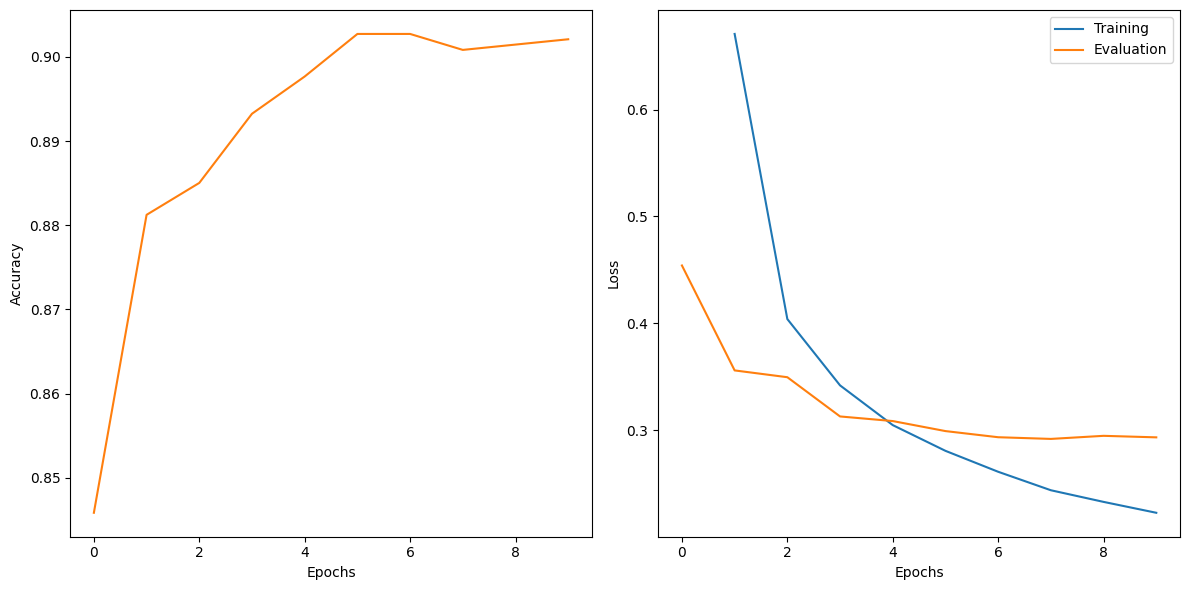

In [30]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axs[0].plot(epochs, train_accs, label="Training")
    axs[0].plot(epochs, eval_accs, label="Evaluation")
    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()
    plt.tight_layout()

def pick_tag(tags, candidates):
    for c in candidates:
        if c in tags:
            return c
    return None

def read_tb_and_plot(logdir="./runs", steps_per_epoch=None):
    event_files = sorted(glob.glob(f"{logdir}/**/events.out.tfevents.*", recursive=True))
    if not event_files:
        raise FileNotFoundError(f"No TensorBoard event files found under: {logdir}")
    event_file = event_files[-1]
    print("Using event file:", event_file)

    ea = EventAccumulator(event_file, size_guidance={"scalars": 0})
    ea.Reload()
    scalar_tags = ea.Tags().get("scalars", [])
    print("Found scalar tags (first 30):", scalar_tags[:30])

    eval_acc_tag  = pick_tag(scalar_tags, ["eval/accuracy", "eval_accuracy"])
    eval_loss_tag = pick_tag(scalar_tags, ["eval/loss", "eval_loss"])
    train_loss_tag = pick_tag(scalar_tags, ["train/loss", "loss", "train_loss"])
    train_acc_tag  = pick_tag(scalar_tags, ["train/accuracy", "train_accuracy"])

    if eval_acc_tag is None or eval_loss_tag is None:
        raise ValueError(
            "Could not find eval accuracy/loss tags in TensorBoard."
            "Make sure you set report_to='tensorboard' and evaluation_strategy='epoch' (or steps)."
        )

    def get_scalar(tag):
        evs = ea.Scalars(tag)
        steps = np.array([e.step for e in evs], dtype=int)
        vals  = np.array([e.value for e in evs], dtype=float)
        idx = np.argsort(steps)
        return steps[idx], vals[idx]

    eval_steps_acc, eval_accs = get_scalar(eval_acc_tag)
    eval_steps_loss, eval_losses = get_scalar(eval_loss_tag)

    n_eval = min(len(eval_accs), len(eval_losses))
    eval_accs = eval_accs[:n_eval].tolist()
    eval_losses = eval_losses[:n_eval].tolist()

    if train_loss_tag is not None:
        train_steps, train_losses_steps = get_scalar(train_loss_tag)

        if steps_per_epoch is None:
            if len(eval_steps_loss) >= 2:
                steps_per_epoch = int(eval_steps_loss[1] - eval_steps_loss[0])
                print("Inferred steps_per_epoch =", steps_per_epoch)
            else:
                steps_per_epoch = max(train_steps.max(), 1)
                print("Fallback steps_per_epoch =", steps_per_epoch)

        epoch_ids = (train_steps // steps_per_epoch).astype(int)

        train_losses = []
        for e in range(n_eval):
            mask = (epoch_ids == e)
            if mask.any():
                train_losses.append(float(train_losses_steps[mask].mean()))
            else:
                train_losses.append(float("nan"))
    else:
        train_losses = [float("nan")] * n_eval

    if train_acc_tag is not None:
        _, train_accs = get_scalar(train_acc_tag)
        train_accs = train_accs[:n_eval].tolist()
    else:
        train_accs = [float("nan")] * n_eval

    num_epochs = n_eval
    plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

    plt.savefig("results.pdf")
    plt.savefig("results.png")
    print("Saved: results.pdf and results.png")

read_tb_and_plot(logdir="./vsfc-distilbert-base-uncased/runs", steps_per_epoch=None)

##**7. Evaluation**

In [31]:
train_results = trainer.evaluate(processed_dataset["train"])
print(f"Train Set:      {train_results}")

val_results = trainer.evaluate(processed_dataset["validation"])
print(f"Validation Set: {val_results}")

test_results = trainer.evaluate(processed_dataset["test"])
print(f"Test Set:       {test_results}")

Train Set:      {'eval_loss': 0.19980640709400177, 'eval_accuracy': 0.9369858218099072, 'eval_runtime': 29.0667, 'eval_samples_per_second': 393.096, 'eval_steps_per_second': 1.548, 'epoch': 10.0}
Validation Set: {'eval_loss': 0.2916719615459442, 'eval_accuracy': 0.9008212255211624, 'eval_runtime': 4.1895, 'eval_samples_per_second': 377.85, 'eval_steps_per_second': 1.671, 'epoch': 10.0}
Test Set:       {'eval_loss': 0.3659992218017578, 'eval_accuracy': 0.8843967150979154, 'eval_runtime': 8.3566, 'eval_samples_per_second': 378.863, 'eval_steps_per_second': 1.556, 'epoch': 10.0}


In [32]:
predictions = trainer.predict(processed_dataset["test"])
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

label_names = ["Negative", "Neutral", "Positive"]
print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

    Negative       0.88      0.94      0.90      1409
     Neutral       0.53      0.14      0.23       167
    Positive       0.90      0.92      0.91      1590

    accuracy                           0.88      3166
   macro avg       0.77      0.67      0.68      3166
weighted avg       0.87      0.88      0.87      3166

